<a href="https://colab.research.google.com/github/ralsouza/apache_spark_real_time_analytics/blob/master/notebooks/11_pyspark_mllib_clustering_k_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering K-Means

**Description:**
*   Unsupervised algorithm;
*   Grouping data by simility;
*   Partitions the data by a `k` number of clusters, with each observation belongs to a just one cluster;
*   The clusterizations is made measuring the distance between the data points and grouping them;
*   Multiple distance measures may be used, such as, `Euclidian Distance` and `Manhattan Distance`;

**Advantages:**
*   Faster;
*   Efficient to many variables;

**Disvantages:**
*   The `k` value must be know;
*   The initial value of `k` influences on created clusters;

**Application:**
*   Priliminary grouping before applying classification techniques;
*   Geographic clustering;



# Setup Spark


In [ ]:
!apt-get update

In [2]:


# Install the dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [3]:
# Environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [4]:
# Make pyspark "importable"
import findspark
findspark.init('spark-2.4.4-bin-hadoop2.7')

In [5]:
# Libraries and Context Setup
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)


# Instance Spark Session
spark = SparkSession.builder.master('local').appName('spark_ml_lib').getOrCreate()

# Create the SQL Context
sqlContext = pyspark.SQLContext(sc)

# Grouping cars

In [8]:
# Libraries
import math
import pandas as pd
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
import matplotlib.pylab as plt
%matplotlib inline

In [9]:
# Spark Session
sp_session = SparkSession.builder.master('local').appName('app_spark_mllib').getOrCreate()

In [10]:
# Load data
rdd_cars = sc.textFile('/content/drive/My Drive/Colab Notebooks/08-apache-spark/data/mllib/carros2.csv')

In [11]:
rdd_cars.cache()

/content/drive/My Drive/Colab Notebooks/08-apache-spark/data/mllib/carros2.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [12]:
# Remove the header
first_row = rdd_cars.first()
rdd_cars2 = rdd_cars.filter(lambda x: x != first_row)
rdd_cars2.count()

197

In [ ]:
rdd_cars2.take(5)

['subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348',
 'mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,37,41,5389']

In [13]:
# Converting and cleaning
def transform_to_numeric(input_str):
  
  att_list = input_str.split(',')

  doors = 1.0 if att_list[3] == 'two' else 2.0
  body = 1.0 if att_list[4] == 'sedan' else 2.0

  rows = Row(DOORS = doors, BODY = float(body), HP = float(att_list[7]), 
             RPM = float(att_list[8]), MPG = float(att_list[9]))
  
  return rows

In [14]:
# Apply function
rdd_cars3 = rdd_cars2.map(transform_to_numeric)

# Persist in memory, could be .cache()
rdd_cars3.persist()

rdd_cars3.take(3)

[Row(BODY=2.0, DOORS=1.0, HP=69.0, MPG=31.0, RPM=4900.0),
 Row(BODY=2.0, DOORS=1.0, HP=48.0, MPG=47.0, RPM=5100.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=30.0, RPM=5000.0)]

In [15]:
# Transform to dataframe
df_cars = sp_session.createDataFrame(rdd_cars3)
df_cars.show(5)

+----+-----+----+----+------+
|BODY|DOORS|  HP| MPG|   RPM|
+----+-----+----+----+------+
| 2.0|  1.0|69.0|31.0|4900.0|
| 2.0|  1.0|48.0|47.0|5100.0|
| 2.0|  1.0|68.0|30.0|5000.0|
| 2.0|  1.0|62.0|35.0|4800.0|
| 2.0|  1.0|68.0|37.0|5500.0|
+----+-----+----+----+------+
only showing top 5 rows



In [16]:
# Summarizing with Pandas
desc_cars = df_cars.describe().toPandas()

In [17]:
# Show dataframe
desc_cars

,summary,BODY,DOORS,HP,MPG,RPM
0,count,197,197,197,197,197
1,mean,1.532994923857868,1.5685279187817258,103.60406091370558,25.15228426395939,5118.0203045685275
2,stddev,0.5001812579359883,0.49654352778167493,37.639205349518356,6.437862917085915,481.03591405011446
3,min,1.0,1.0,48.0,13.0,4150.0
4,max,2.0,2.0,262.0,49.0,6600.0


In [18]:
# Get means and deviations converting to lists
cars_means = desc_cars.iloc[1,1:5].values.tolist()
cars_devs  =  desc_cars.iloc[2,1:5].values.tolist()

In [ ]:
cars_means

['1.532994923857868',
 '1.5685279187817258',
 '103.60406091370558',
 '25.15228426395939']

In [ ]:
cars_devs

['0.5001812579359883',
 '0.49654352778167493',
 '37.639205349518356',
 '6.437862917085915']

In [19]:
# Store the variables to the broadcast variables - broadcast variables are read-only
bc_means = sc.broadcast(cars_means)
bc_devs = sc.broadcast(cars_devs)

In [26]:
# Function to centralize and apply a scale on data. Each value will be subtracted
# from the mean and then divided by the standard deviation

def center_and_scale(row):
  
  global cars_means
  global cars_devs

  mean_array = bc_means.value
  std_dev    = bc_devs.value 

  ret_array = []

  for i in range(len(mean_array)):
    ret_array.append(float((row[i]) - float(mean_array[i])) / float(std_dev[i]))

  return Vectors.dense(ret_array)

In [27]:
rdd_cars4 = df_cars.rdd.map(center_and_scale)

In [29]:
rdd_cars4.collect()[:10]

[DenseVector([0.9337, -1.145, -0.9194, 0.9083]),
 DenseVector([0.9337, -1.145, -1.4773, 3.3936]),
 DenseVector([0.9337, -1.145, -0.9459, 0.753]),
 DenseVector([0.9337, -1.145, -1.1053, 1.5297]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403]),
 DenseVector([0.9337, -1.145, -1.1585, 1.9956]),
 DenseVector([-1.0656, -1.145, -0.9194, 0.9083]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403]),
 DenseVector([0.9337, -1.145, -0.9459, 0.9083])]

In [30]:
# Creating the dataframe
rdd_cars5 = rdd_cars4.map(lambda f: Row(features = f))
df_cars = sp_session.createDataFrame(rdd_cars5)
df_cars.select('features').show(10)

+--------------------+
|            features|
+--------------------+
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[-1.0656035495158...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
+--------------------+
only showing top 10 rows



In [33]:
# Creating the model
kmeans = KMeans(k=3,seed=1)
model = kmeans.fit(df_cars)

In [35]:
# Show predictions - Note that doesn't exist a train dataset
pred = model.transform(df_cars)
pred.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[-1.0656035495158...|         0|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[-1.0656035495158...|         0|
+--------------------+----------+
only showing top 20 rows



In [37]:
# After many transformations, we need to make a reverse engineering to get the features back

def unstrip_data(input):
  return (input['prediction'], input['features'][0], input['features'][1], input['features'][2], input['features'][3])

In [39]:
rdd_cars6 = pred.rdd.map(unstrip_data)
pred_list = rdd_cars6.collect()
pred_pd = pd.DataFrame(pred_list)

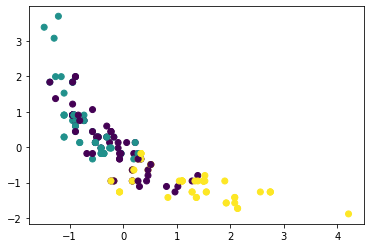

In [41]:
# Show clusters by similarity

plt.cla()
plt.scatter(pred_pd[3],pred_pd[4],c=pred_pd[0])
plt.show()